c:\Users\cayez\Documents\DONNEES_SIMON\Enseignements\NINO_workshop\Notebooks\part2_synchrotron\synchrotron11



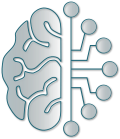

**Start at:** Wednesday 24 September 2025, 14:44:42  
**Hostname:** insa-09521 (Windows)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
import os
import sys

print(os.getcwd())
cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import fg,bg,hl,color
vID.init(cwd0)

import tools4pyPhysChem as t4pPC

#cancel the "last show-up" behaviour of Jupyter notebooks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

__author__ = "Simon Cayez, LPCNO / Département Génie Physique (INSA Toulouse, France)"

<h2 style="text-align: center;">
  <b><u>Dataset Preparation</u>:<br>
  Step 1 – Image Processing</b>
</h2>


## Introduction:

In this workshop we will work with µSAXS (Micro-Small-Angle-X-Ray Scattering) data from  SOLEIL synchrotron, beamline SWING. This technique gives access to information about geometry and structure of nanoparticles assemblies.
C. Hamon and his group created  micrometrics molds with different geometries (in this example circle, square and triangle) and filled them with a colloidal solution of gold nanorods. The nanorod orientation is dependant on the mold geometry.


<!-- Tableau pour l'image principale, sans bordures -->
<table style="border-collapse:collapse; border:none; margin-left:auto; margin-right:auto;">
  <tr>
    <td style="text-align:center; border:none;">
      <img src="figures/fig0.png" width="800">
    </td>
  </tr>
</table>

<!-- Tableau pour la légende, sans bordures -->
<table style="border-collapse:collapse; border:none; margin-left:auto; margin-right:auto; width:800px;">
  <tr>
    <td style="text-align:justify; font-size:14px; border:none;">
      <i>
        <b>Fig. 0.</b> Synchrotron acquisition on gold nanorods in molds of different shapes.<br><br>
        <b>A)</b> Process for molds fabrication: Confine, Evaporation-Induced Self-Assembly, Peel Off<br>
        <b>B)</b> Geometry and dimensions of molds<br>
        <b>C)</b> Optical microscope image with dimension order of SAXS/µSAXS beam size<br>
        <b>D)</b> S.E.M. Image of a triangle mold filled with Au Nanorods<br>
        <b>E)</b> Au Nanorods organization in the mold<br>
        <b>F)</b> SAXS images
      </i>
    </td>
  </tr>
</table>



Chaâbani, W.; Lyu, J.; Marcone, J.; Goldmann, C.; ten Veen, E. J. M.; Dumesnil, C.; Bizien, T.; Smallenburg, F.; Impéror-Clerc, M.; Constantin, D.; Hamon, C. *Prismatic Confinement Induces Tunable Orientation in Plasmonic Supercrystals.* **ACS Nano** **2024**, 2024, 18, 13, 9566-9575. [https://doi.org/10.1021/acsnano.3c12799](https://doi.org/10.1021/acsnano.3c12799). </pre>

In this workshop, we will work with a dataset of **1800 images** in **3 folders** named **"circle", "triangle" and "square"** with around 600 µSAXS images for each geometry.  The aim is to **prepare the dataset** in order to use it for **deep learning** image **classification** with a 2D Convolutional Network.  
Building the dataset is a key point for the success of all machine learning processes. It is common to obtain bad predictions due to poor data preparation.
The steps will be:  


- **Extract** images from structured *.nxs or *.h5 files  
- Build **NumPy array**s containing images  
- **Reshape** the NumPy arrays  
- Explore the dataset by sample **image visualization** 
- Explore and adapt **pixel values** 
- **Crop** images  
- Visualize the dataset as a **video**  
- **Normalize** pixels in the range 0–1  
- **Resize** images  
- **Concatenate** the data from circle, square, and triangle to build X  
- Create a **labels** array  
- **Shuffle** the data  
- **Split** the data into **train and test** sets  
- Prepare a **Convolutional Neural Network**  
- **Train** it  
- Make **predictions** on the test dataset  
- **Evaluate** the quality of the model  

In our dataset, we have **three classes** corresponding to the mold geometries:  

- `circle`  
- `triangle`  
- `square`  

In this workshop, we will process each class **separately** to explore and manipulate the images.  
In the  notebook [`dataset_creation.ipynb`](dataset_creation.ipynb), we will **combine all classes** to build a complete dataset suitable for training a neural network.


### Workflow Roadmap

The figures below provide a visual **roadmap** of the steps we will follow during the workshop.  
Each block corresponds to a key stage in the data preparation.  
Variable names, functions, and loops that you will encounter in the notebook are already indicated inside the diagrams.  

This roadmap will help you:
- Understand the overall workflow  
- See how individual steps (data extraction, reshaping, visualization, normalization, model building, training, evaluation…) connect to each other,
- Quickly locate where a variable or function will be used in the code.

You can refer back to this roadmap at any time as you progress through the notebook.


<table style="border-collapse:collapse; border:none; margin-left:auto; margin-right:auto;">
  <tr>
    <td style="text-align:center; border:none;">
      <img src="figures/fig7.png" width="350">
    </td>
    <td style="text-align:center; border:none;">
      <img src="figures/fig8.png" width="450">
    </td>
  </tr>
</table>

## 1- Import data

Before we start, please download the datasets from the following links. You will find a dataset for each geometry.  
To begin with, download only the ‘square’ dataset:  
   
[Download µSAXS 'square' dataset](https://your-download-link-here)  
[Download µSAXS 'circle' dataset](https://your-download-link-here)  
[Download µSAXS 'triangle' dataset](https://your-download-link-here)  

For training a neural network, it is generally necessary to have **hundreds or even thousands of images** in the dataset to achieve good performance. In this workshop we have arond 600 images per class.
In case of issue with downloading or handling big datasets, a smaller dataset of only a few dozen images is available:  
  
[Download µSAXS 'square' light_dataset](https://your-download-link-here)  
[Download µSAXS 'circle' light_dataset](https://your-download-link-here)  
[Download µSAXS 'triangle' light_dataset](https://your-download-link-here)  
  

These files are `*.npy` files. They were obtained by **extracting** form `*.nxs` files.  
   
In synchrotron facilities, experimental data are often stored in **NeXus (`.nxs`) files**, which are based on the HDF5 format.    
These files contain a large amount of structured information (metadata, instrument settings, measurement results, etc).    

For this workshop, we are interested only in the **images** recorded during the experiment.   
To simplify the workflow, we used a helper function called `extract_nxs_folder` (defined in `extract.py`).  
This function reads all the `.nxs` files inside a specified folder and **extracts the corresponding images into NumPy arrays** that we can process further.   
In the workshop we will start with `*.npy` files to avoid the handling of big quantity of quite heavy `*.nxs` files, but to give access to the whole workflow, the process is detailed in the notebook [`nxs_extraction.ipynb`](nxs_extraction.ipynb)    
   
The original `*.nxs files` are available at this [link](https://your-download-link-here)    
  
If you want to quickly **preview the content of a `.nxs`/`.h5` file without writing code**, you can use the free online viewer provided by the HDF Group: [https://myhdf5.hdfgroup.org/](https://myhdf5.hdfgroup.org/).

After selecting only the first channel, the array `first_channels` has the shape `(n, 1083, 1035)`.  
This means we now have **n images**, each with a resolution of **1083 × 1035 pixels**.

If you want to skip the extraction step, the preprocessed **first channel files** are available for download here:  
[Download first_channel `.npy` files](https://drive.google.com/file/d/14HzSaj4-STwZ1RZHOjRxR3EURlzmR1kT/view?usp=drive_link)


In [2]:
import numpy as np
geometry = 'circle'
file_path = f"data/{geometry}_raw.npy"
data_raw = np.load(file_path)


## 2 Explore data format

### 2-1 Shape and dimensions

We first inspect the **number of dimensions** and the **shape** of the NumPy array to understand its structure (how many images and their size)

In [3]:
# Check the number of dimensions and the shape of the array
print(f"Number of dimensions : {data_raw.ndim}")
print(f"Shape  : {data_raw.shape}")

Number of dimensions : 3
Shape  : (616, 1083, 1035)


The loaded NumPy array has shape **(n, 1083, 1035)**:

- **n** = number of images  
- **1083** = image height (pixels)  
- **1035** = image width (pixels)

It is therefore a **3-D** array where each slice along the first axis is one image of **size 1083×1035 pixels**.


In this section, we will focus on **visualizing the µSAXS images** we extracted and preprocessed.  

Since the dataset can contain **large numbers of high-resolution images**, it is important to explore them efficiently and to check for any unexpected artifacts or anomalies.  


### 2-2 Plot images


We will use **Matplotlib**, a Python library for plotting graphs and displaying images, to visualize our dataset.  

Since `first_channels` is a NumPy array containing multiple images, we **slice the array** to select only the first image (`index 0`) for display.

Text(0.5, 1.0, 'First image raw')

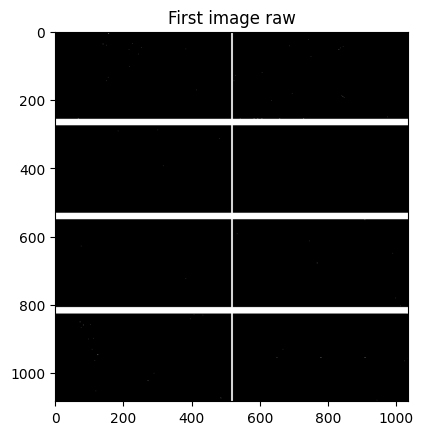

In [4]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

# Display the first image in the first_channels array
# raw_data[0, :, :] selects the first image (all rows and columns)
# cmap='gray' ensures the image is shown in grayscale
ax.imshow(data_raw[0, :, :],cmap='gray')
ax.set_title("First image raw")

We can also display **multiple images side by side** to compare them easily.  
Here, we will show the first three images from `first_channels` using subplots in Matplotlib.

Text(0.5, 1.0, 'Image 0 raw')

Text(0.5, 1.0, 'Image 1 raw')

Text(0.5, 1.0, 'Image 2 raw')

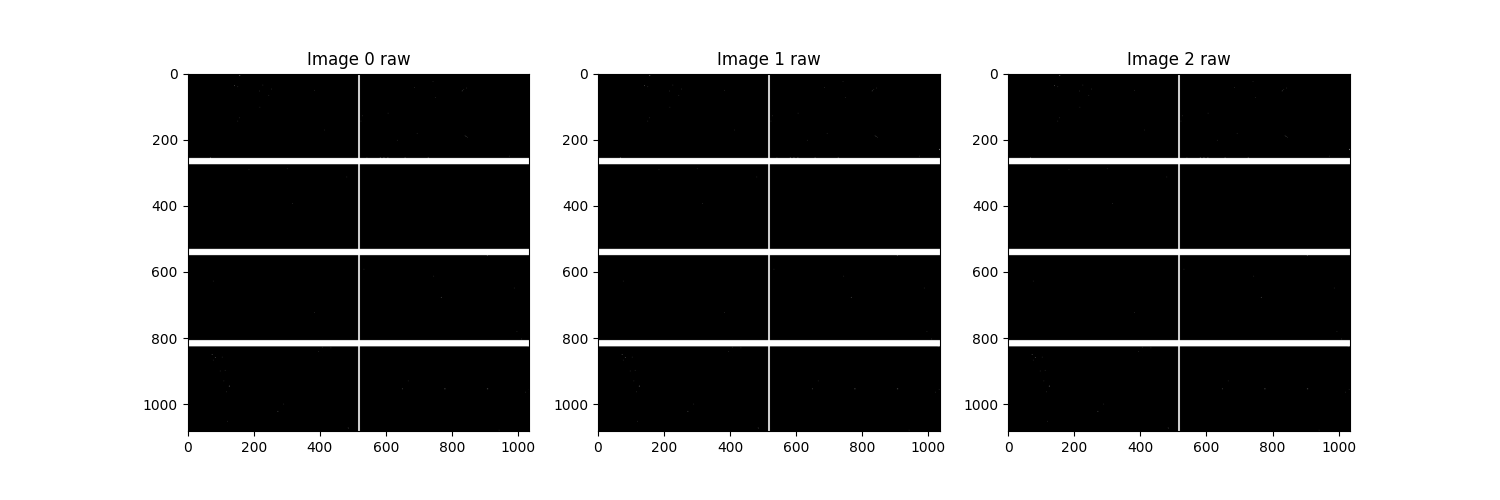

In [ ]:
# Create a figure with 1 row and 3 columns of subplots
# figsize=(15,5) sets the width and height of the figure in inches
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Loop over the first three images
for i in range(3):
    # Display the i-th image in grayscale on the corresponding subplot
    axes[i].imshow(data_raw[i, :, :],cmap='gray')
    # Add a title to each subplot
    axes[i].set_title(f"Image {i} raw")

On the images we just plotted, you may notice that the scattering patterns are **hard to see**: most of the pixels have relatively low intensity values, while a few pixels are very bright.  

In SAXS experiments, the intensity of scattered X-rays can **span several orders of magnitude**. Using a **logarithmic scale** allows us to:

- Better visualize **both low and high intensity regions** in the same image  
- Highlight subtle features in the scattering patterns that would otherwise be invisible  

Next, we will apply a logarithmic transformation to the images to make the structures more apparent.


### 2-3- Log scale

Text(0.5, 1.0, 'Log image 0')

Text(0.5, 1.0, 'Log image 1')

Text(0.5, 1.0, 'Log image 2')

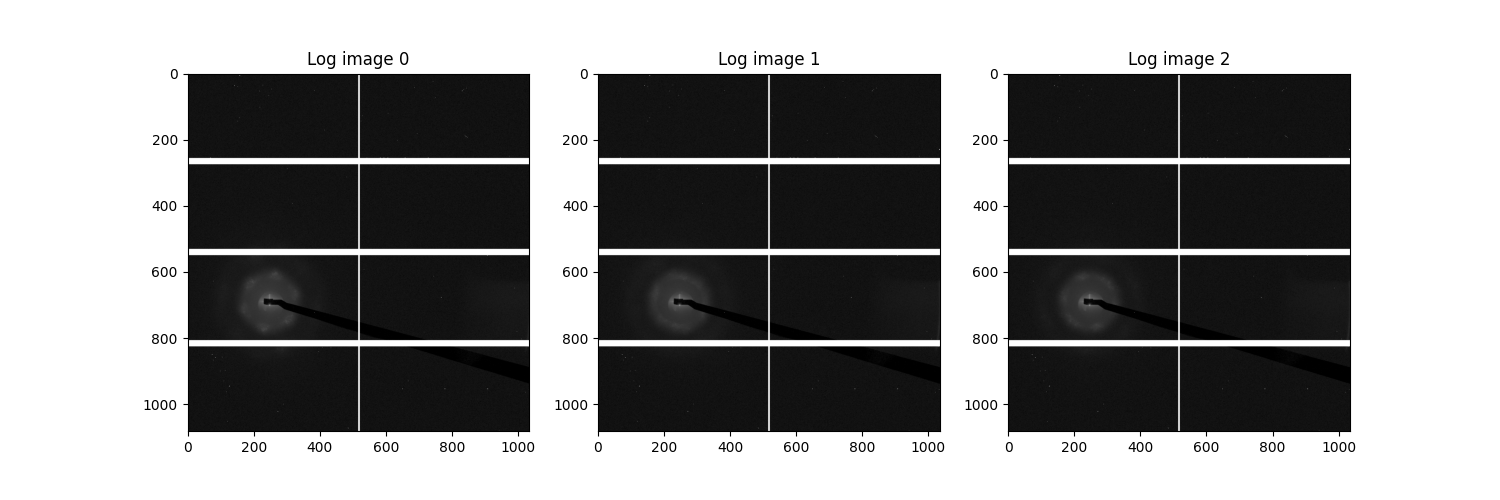

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i in range(3):
    # np.log1p(x) computes log(1 + x) to avoid log(0) and enhance contrast
    axes[i].imshow(np.log1p(data_raw[i, :, :]),cmap='gray') 
    axes[i].set_title(f"Log image {i}")

#### 2-3-1- Apply Logarithmic Transformation to the Data

So far, we have only **visualized** the images using a logarithmic scale, but the underlying NumPy array **has not been modified**.  

To enhance contrast and better handle the wide range of intensities in µSAXS images, we will now **apply a logarithmic transformation directly to the NumPy array**.  
This will update the data itself, so subsequent processing (normalization, resizing, or feeding into a neural network) will use the transformed values.  
We typically use `np.log1p()` to safely compute `log(1 + x)`, which avoids issues with zero-intensity pixels.


In [40]:
#apply a logarithmic transformation directly to the NumPy array
data_log = np.log1p(data_raw)

#### 2-3-2- Image statistics

##### 📝 Exercise: Print Image Statistics

**Goal:** Create a function that prints the **minimum, maximum, mean, and median** pixel values of a selected image in a dataset.

**Instructions:**

- **Function name:** `print_image_stats`
- **Arguments:**
  - `images` : a NumPy array of shape `(n_images, width, height)`  
  - `image_index` : the index of the image to analyze (default: 0)
- **Returns:**  
  - Nothing, only prints the statistics in a clear format

**Steps:**
1. Select the image at `image_index` from `images`.
2. Compute the `min`, `max`, `mean`, and `median` values of the image.
3. Print them in a readable table format.

Implement the function below in a file called `visualization.py ` saved in the **current directory**.  


**Example of expected print output (numbers are illustrative):**
<pre>
Statistic Value
Min 0.0000  
Max 123.4567  
Mean 12.3456  
Median 10.0000  
</pre>

In [41]:
from vizualisation import print_image_stats

print_image_stats(data_raw, image_index=0)
print_image_stats(data_log, image_index=0)

Statistic            Value
--------------------------
Min                 0.0000
Max             4294967295.0000
Mean            246102197.1883
Median              5.0000
**************************************************
Statistic            Value
--------------------------
Min                 0.0000
Max                22.1807
Mean                2.8842
Median              1.7918
**************************************************


### 2-4 Check all images with a video

##### 📝 Exercise: Create a Video from Images

**Goal:** Create a function that converts a sequence of images into a **video file** for fast visualization of the dataset.

**Instructions:**

- **Function name:** `create_video_from_images`  
- **Arguments:**
  - `images` : a NumPy array of shape `(n_images, height, width)`  
  - `output_path` : path where the video file will be saved (default `'output_video.mp4'`)  
  - `fps` : frames per second (speed of the video, default `5`)
- **Returns:**  
  - Nothing, the function should save a video file to `output_path`  
- **Save the function in:** `visualization.py`

**Steps:**
1. Read the number of images and their dimensions from the array.  
2. Create a `cv2.VideoWriter` object with the correct codec, frame size, and FPS.  
3. Loop over the images, normalize pixel values to 0–255, convert to `uint8`, and write each frame to the video.  
4. Release the `VideoWriter` and print a confirmation with the video details.

**Example usage:**

```python
# Create a video from the log-transformed dataset
create_video_from_images(data_log, output_path='data_log_video.mp4', fps=5)


In [10]:
from vizualisation import create_video_from_images
create_video_from_images(data_log, geometry+'_video.mp4', fps=6)

Creating video with 616 frames at 6 FPS...
Processed frame 1/616
Processed frame 5/616
Processed frame 10/616
Processed frame 15/616
Processed frame 20/616
Processed frame 25/616
Processed frame 30/616
Processed frame 35/616
Processed frame 40/616
Processed frame 45/616
Processed frame 50/616
Processed frame 55/616
Processed frame 60/616
Processed frame 65/616
Processed frame 70/616
Processed frame 75/616
Processed frame 80/616
Processed frame 85/616
Processed frame 90/616
Processed frame 95/616
Processed frame 100/616
Processed frame 105/616
Processed frame 110/616
Processed frame 115/616
Processed frame 120/616
Processed frame 125/616
Processed frame 130/616
Processed frame 135/616
Processed frame 140/616
Processed frame 145/616
Processed frame 150/616
Processed frame 155/616
Processed frame 160/616
Processed frame 165/616
Processed frame 170/616
Processed frame 175/616
Processed frame 180/616
Processed frame 185/616
Processed frame 190/616
Processed frame 195/616
Processed frame 200

## 3- Crop images

### 3-1 Select crop coordinates

By watching the video, we can see that the scattering signal always appears in the **same region** of the images.  
To reduce the dataset size and focus the model on the relevant features, we will **crop each image** to keep only the region containing the signal.

First, let's **visualize the first image** to decide the cropping boundaries:

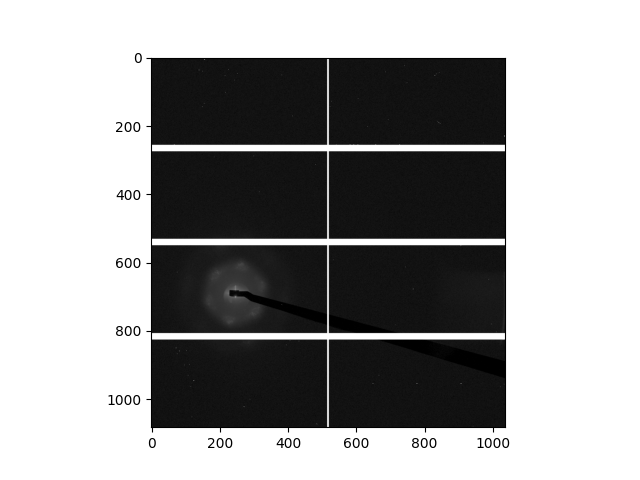

In [11]:
%matplotlib widget
fig, ax = plt.subplots()
ax.imshow(data_log[0,:, :],cmap='gray')

**Visually inspect different slices** of the first image by trying various ranges for the `x` (columns) and `y` (rows) coordinates.  

Crop image of index zero to obtain a square image of arond 240x240 pixels


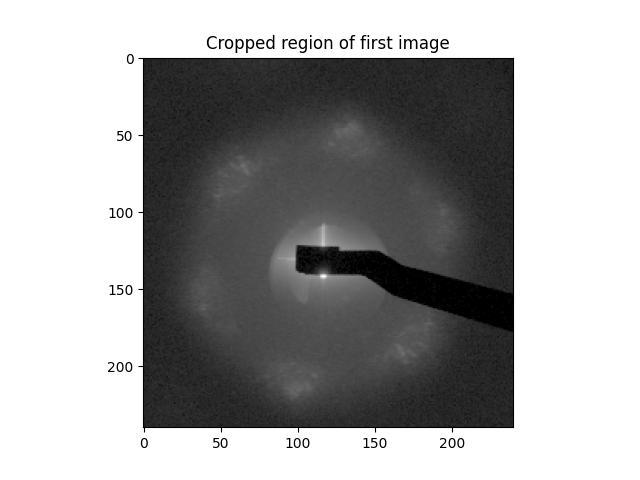

In [42]:
# Define the crop ranges
rows = slice(560, 800)  # y-range
cols = slice(130, 370)  # x-range

# Visualize the cropped region of the first image
fig, ax = plt.subplots()
ax.imshow(data_log[0, rows, cols], cmap='gray')
ax.set_title("Cropped region of first image");

In [13]:
data_crop = data_log[:,rows, cols]
print("Before Crop :", data_log.shape)
print("After Crop :", data_crop.shape)

Before Crop : (616, 1083, 1035)
After Crop : (616, 240, 240)


In [14]:
print("Before Crop :", data_log.shape)
print("After Crop :", data_crop.shape)

Before Crop : (616, 1083, 1035)
After Crop : (616, 240, 240)


## 4- Pixels Values

In this section, we will **explore the distribution of pixel values** in our images with statistics and histograms.   

This step is important because:  

- It helps us **identify extreme values (outliers)** that may distort the training of a neural network.  
- It indicates whether **pre-processing** (normalization, clipping, or outlier removal) might be necessary before training.  
- It provides a clearer picture of the **intensity ranges** that the model will have to handle.  



### 4-1- Statistics

We will now reuse the previously defined `print_image_stats` function to inspect our image of index 0.

In [15]:
from vizualisation import print_image_stats
print_image_stats(data_crop, image_index=0)

Statistic            Value
--------------------------
Min                 0.0000
Max                15.1414
Mean                3.3790
Median              2.9957
**************************************************



From the computed statistics we observe:

- The **mean**  and **median**  are much closer to the **minimum** value  than to the **maximum** value.  
- The **mean** is also noticeably higher than the **median**.  

This suggests that the pixel value distribution is not balanced. We can verify this by plotting the histogram of the image.

### 4-2 Histograms

##### 📝 Exercise: Plot Image Histogram

**Goal:** Create a function that plots the **histogram of pixel values** of a selected image from a dataset.

**Instructions:**

- **Function name:** `plot_image_histogram`  
- **Arguments:**
  - `data` : a NumPy array of shape `(n_images, height, width)`  
  - `image_index` : index of the image to plot (default: `0`)  
  - `bins` : number of bins for the histogram (default: `100`)  
- **Returns:**  
  - Nothing, the function should display the histogram of pixel values.  
- **Save the function in:** `visualization.py`

**Steps:**
1. Select the 2D image at `image_index` from `data`.  
2. Flatten the image with `.ravel()` to get all pixel values in a 1D array.  
3. Plot the histogram using `matplotlib.pyplot.hist`.  
4. Add clear axis labels (“Pixel value” / “Number of pixels”) and a descriptive title indicating the image index.  
5. Display the plot with `plt.show()`.

**Example usage:**

```python
# Plot the histogram of the first cropped image
plot_image_histogram(data_crop, image_index=0, bins=100)


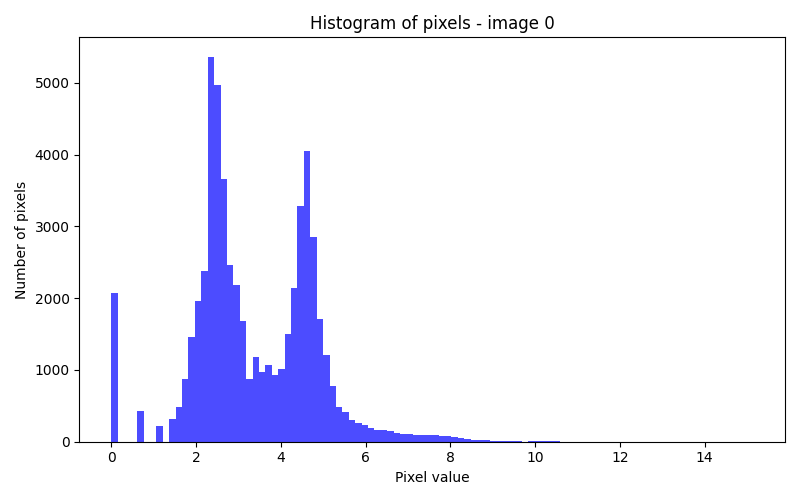

In [16]:
from vizualisation import plot_image_histogram
plot_image_histogram(data_crop) 

We observe that there are a few high pixel values in the image.  

Try to **locate these outliers** by plotting red markers on pixels that exceed a chosen threshold in the first image.  
You will likely need to **zoom in** on the image to clearly see the high-value pixels.


### 4-3- Vizualise outliers


##### 📝 Exercise: Highlight Pixels Above Threshold

**Goal:** Create a function that displays a 2D image and **marks all pixels above a given threshold** in red.

**Instructions:**

- **Function name:** `show_image_with_pixels_over_threshold`  
- **Arguments:**
  - `image` : a 2D NumPy array of shape `(height, width)`  
  - `threshold` : pixel value threshold to highlight  
- **Returns:**  
  - Nothing, the function should display the image with marked pixels and print the number of pixels above the threshold.  
- **Save the function in:** `visualization.py`

**Steps:**
1. Identify the coordinates of all pixels where the value is greater than `threshold`.  
2. Plot the image using `matplotlib.pyplot.imshow` with a grayscale colormap.  
3. Overlay the detected pixels as red markers using `plt.scatter`.  
4. Add a title indicating the threshold value, hide axes, and include a legend.  
5. Display the plot and print the total number of pixels above the threshold.  

**Example usage:**

```python
# Highlight pixels above threshold 20 in the first cropped image
show_image_with_pixels_over_threshold(data_crop[0], threshold=8)


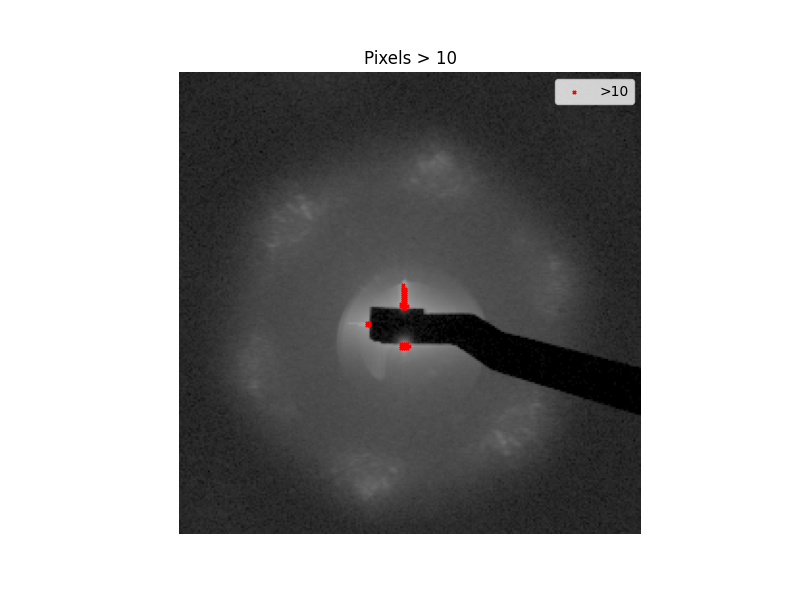

Number of pixels > 10: 44


In [17]:
from vizualisation import show_image_with_pixels_over_threshold
threshold = 10
show_image_with_pixels_over_threshold(data_crop[0,:,:], threshold=threshold)

We can now **localize the strong pixel values** in a single image.  
However, analyzing just one picture may not be representative of the dataset.  

We will display **6 images** by passing **6 random indices** to your function to explore high-value pixels across multiple images.


To get a representative view of the dataset, we don’t want to display the first 6 images or just any sequential subset.  
Instead, we **randomly select 6 image indices**. This ensures that we visualize a variety of images across the dataset and can inspect different features, like high-value pixels, across multiple samples.


In [18]:
import random
# Randomly select 6 indices from the first dimension
n_images = data_raw.shape[0]
random_indices = random.sample(range(n_images), 6)
print(random_indices)

[427, 143, 252, 306, 203, 508]


##### 📝 Exercise: Display 6 Random Images with Optional Threshold

**Goal:** Create a function that displays **6 images** in a 2×3 grid. Optionally, mark the pixels above a given threshold in red.

**Instructions:**

- **Function name:** `plot_6images`  
- **Arguments:**
  - `data` : 3D NumPy array of shape `(n_images, width, height)`  
  - `indices` : list of 6 integer indices to display  
  - `threshold` : float, optional, pixels above this value are highlighted 
  - `show_threshold` : bool, optional, whether to show pixels above threshold  
  - `figsize` : tuple, optional, size of the figure 
  - `cmap` : str, optional, colormap to use  

- **Returns:**  
  - Nothing; displays a 2×3 grid of images, optionally highlighting pixels above the threshold.

- **Steps:**
1. Check that `indices` contains exactly 6 elements.  
2. Loop over the 6 selected indices and plot each image in a subplot.  
3. If `show_threshold` is True and `threshold` is set, overlay red markers on pixels exceeding the threshold.  
4. Remove axes and set titles for readability.  
5. Use `plt.tight_layout()` and `plt.show()` to display the figure cleanly.

Check on 6 random images with a plot function

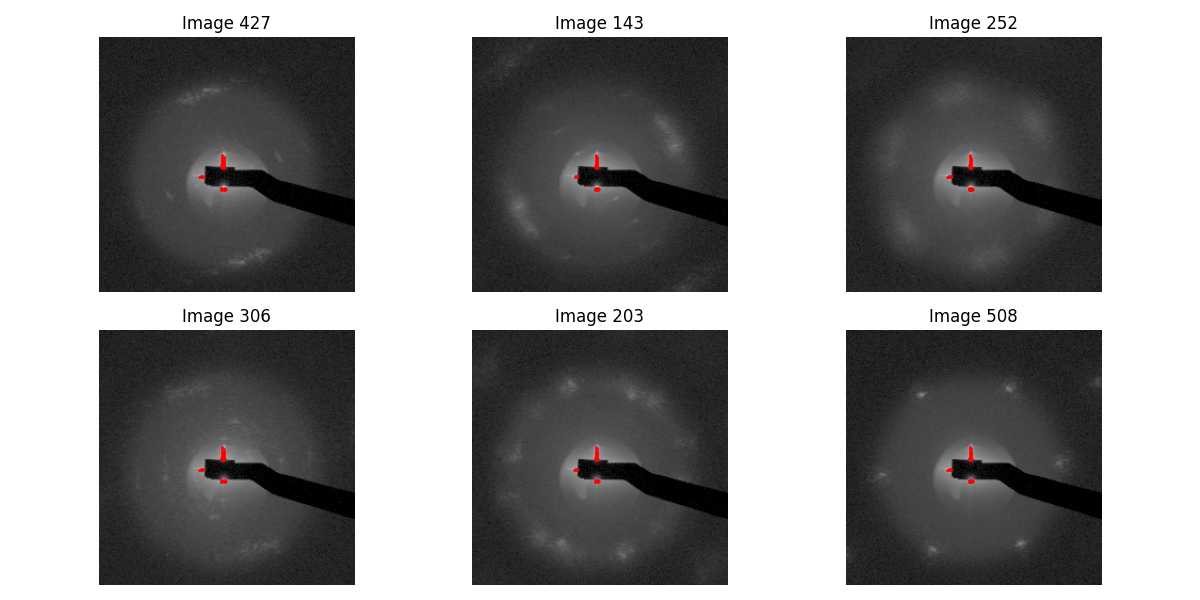

In [19]:
from vizualisation import plot_6images
plot_6images(data_crop, random_indices, threshold=threshold, show_threshold=True)

### 4-4- Clip pixels values

We want an histogram with a good repartition on all the values. 

Most of the pixels above the chosen threshold are located near the **beamstop**, likely originating from the **direct beam**.

In SAXS experiments, the meaningful scattering information is **not expected in this region**, so these extreme values can distort further analysis.

To handle this, we will **cap the pixel values** at the threshold using `numpy.clip`, ensuring that all values above the threshold are set to the threshold value. This reduces the influence of outliers while keeping the rest of the image intact.


In [20]:
data_clip = np.clip(data_crop, min = None, max = threshold)

We will now **check the effect of clipping** by using the previously defined functions `print_image_stats` and `plot_image_histogram`.  

In [21]:
print('Before Clip')
print_image_stats(data_crop, image_index=0)
print('After Clip')
print_image_stats(data_clip, image_index=0)

Before Clip
Statistic            Value
--------------------------
Min                 0.0000
Max                15.1414
Mean                3.3790
Median              2.9957
**************************************************
After Clip
Statistic            Value
--------------------------
Min                 0.0000
Max                10.0000
Mean                3.3780
Median              2.9957
**************************************************


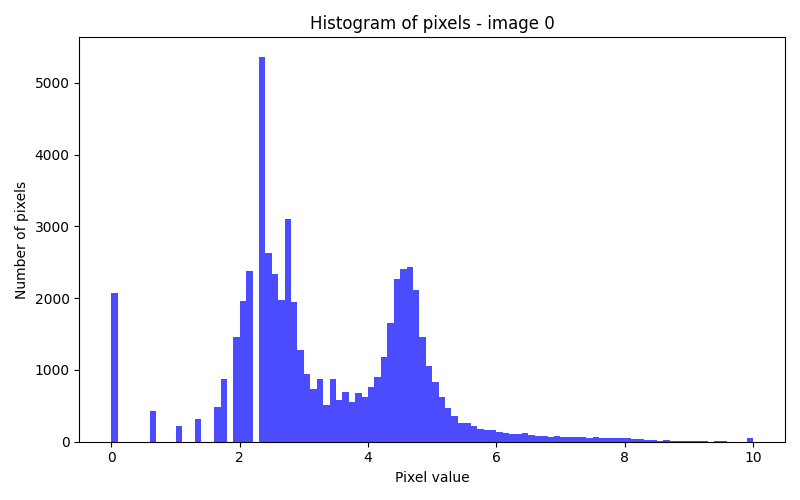

In [22]:
from vizualisation import plot_image_histogram
plot_image_histogram(data_clip) 

After clipping, the data distribution appears more **balanced**, meaning the histogram is more **centered** and the extreme values no longer dominate.  
This makes the dataset easier to interpret and more suitable for training a neural network.

### 4-5- Normalize pixels values

**Normalization** is the process of rescaling data to a standard range, usually between 0 and 1. For images, this means dividing pixel values by a reference value, such as the maximum value of the image or a fixed threshold.

For **deep learning** normlization is benefic because:   

- Neural networks perform better when inputs are on a **similar scale**.  
- It helps **stabilize training** and speeds up **convergence**.  
- Prevents **extreme values** (outliers) from dominating the learning process.  


In this dataset, we normalize each image individually to make the data suitable for training models that predict or classify based on pixel intensity patterns.

In [23]:
# Compute the max of each image along (1,2) axes
data_norm = data_clip / threshold

print(data_clip.shape)
for i in random_indices:
    print_image_stats(data_norm, image_index=0)

(616, 240, 240)
Statistic            Value
--------------------------
Min                 0.0000
Max                 1.0000
Mean                0.3378
Median              0.2996
**************************************************
Statistic            Value
--------------------------
Min                 0.0000
Max                 1.0000
Mean                0.3378
Median              0.2996
**************************************************
Statistic            Value
--------------------------
Min                 0.0000
Max                 1.0000
Mean                0.3378
Median              0.2996
**************************************************
Statistic            Value
--------------------------
Min                 0.0000
Max                 1.0000
Mean                0.3378
Median              0.2996
**************************************************
Statistic            Value
--------------------------
Min                 0.0000
Max                 1.0000
Mean                0.33

## 5- Resize image

For CNNs, **resolution is not a key point** ; smaller images allow handling a **larger number of images** with the same memory footprint

##### 📝 Exercise: Resize Images

**Goal:** Reduce all images in `data_norm` to **128×128 pixels** using `skimage.transform`.  

**Instructions:**  

- Process the 3D array `data_norm` so that each image has shape `(128, 128)`.  
- Verify the result by printing the shape of the new array.  

**Hints:**  
- Use `skimage.transform.resize`.  
- Preserve the number of images.  

In [24]:
from skimage.transform import resize

# data : (N, H, W)
new_h, new_w = 128, 128
data_resized = resize(
    data_norm, 
    (data_norm.shape[0], new_h, new_w),  # même nombre d'images
    order=1,                       # bilinear interpolation
    preserve_range=True,            # garde les valeurs originales (pas normalisé)
    anti_aliasing=True
)
print(data_resized.shape)

(616, 128, 128)


## 5- Save data

Now we have complete the process of image dataset preparation for one of the classes. We will run this notebook for the 2 other shapes (for more a for loop would be required, not done there for keeping notebook readeablity). 
This process will of course vary with other images dataset, but the main ideas remain the same:
- keep only part of the image that can be interpreted by deep learning model:
    - by cropping the region of interest when possible
    - remove outlliers pixels values
- convert pixels values to have a good balance
- apply transformation if necessary as lo here
- normalize the value between 0 and 1

In this dataset all images were coming from the same source but sometime operations of uniformization on size or puxel values are required. 
Noww we will save the data as _data_preprocess.npy to continue by assembling them in a single dataset in the next notebook.

We have now completed the **image dataset preparation** for one of the classes.  
The same steps can be repeated for the other shapes (or automated with a loop), but we avoided this here to keep the notebook readable.

### Key Steps Applied:

- **Focus on relevant regions:**  
  - Crop images to keep only the region containing meaningful signal.  
  - Remove outlier pixel values (extremely high pixels near the beamstop) to avoid biasing the model.

- **Balance pixel values:**  
  - Apply logarithmic transformations to better distribute intensity values.  
  - Normalize pixel values (between 0 and 1, or using the maximum per image) to ensure consistency across the dataset.

- **Resize images:**  
  - Reduce image dimensions (here to 128×128) to allow faster processing and handling of larger datasets in deep learning.

### Notes:

- Although all images in this dataset come from the same source, in other datasets additional uniformization may be necessary:
  - Standardizing image sizes
  - Normalizing intensity ranges
  - Removing noise or artifacts


Finally, the processed images are **saved** in `geometry_data_preprocess.npy`, where `geometry` is one of `'circle'`, `'square'`, or `'triangle'`.  
In the  [dataset_creation_processed_data.ipynb](./dataset_creation_processed_data.ipynb), we will use these three files to assemble the full dataset.


In [25]:
save_path = geometry+"_data_preprocess.npy"
np.save(save_path, data_resized)
print(f"File saved in {save_path}")

File saved in circle_data_preprocess.npy


In [26]:
vID.end(cwd0)


**End at:** Wednesday 24 September 2025, 14:45:12  
**Duration:** 00:00:29 445ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>